In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os

from torchvision.models import ResNet18_Weights, resnet18
from tqdm.notebook import tqdm
from torchvision import datasets, transforms

#from src.imagenet_x.evaluate import ImageNetX, get_vanilla_transform
from src.imagenet_x import FACTORS, plots
from src.imagenet_x import get_factor_accuracies, error_ratio
from src.imagenet_x.utils import load_model_predictions, get_annotation_path

import pickle
from pathlib import Path
import matplotlib.ticker as mtick
import seaborn as sns


In [45]:
get_annotation_path()

PosixPath('/home/juliu/OneDrive/DTU/Bachelor/bachelor_project/src/imagenet_x/annotations')

In [14]:
dfRes = pd.read_csv('Predictions/resnet18.csv')

In [17]:
dfnames= dfRes['file_name']

In [24]:
dfDino = pd.read_csv('Predictions/Dino.csv').merge(dfnames,on='file_name', how='inner')
dfDino.to_csv('Predictions/MDino.csv', index=False)

In [28]:
dfSimCLR = pd.read_csv('Predictions/50kSIMCLR.csv').merge(dfnames,on='file_name', how='inner')
dfSimCLR.to_csv('Predictions/MSIMCLR.csv', index=False)

In [29]:
dfVit = pd.read_csv('Predictions/Vit.csv').merge(dfnames,on='file_name', how='inner')
dfVit.to_csv('Predictions/mVit.csv', index=False)

In [41]:
dfFilenames = pd.read_csv('Predictions/filename_label.csv').merge(dfnames,on='file_name', how='inner')

In [43]:
dfFilenames.to_csv('Mfilename_labels.csv')

In [18]:
models, top_1_accs = load_model_predictions('Predictions')

                              predicted_class  predicted_probability
file_name                                                           
ILSVRC2012_val_00000293.JPEG                0               0.442219
ILSVRC2012_val_00002138.JPEG                0               0.905526
ILSVRC2012_val_00003014.JPEG                0               0.869040
ILSVRC2012_val_00006697.JPEG                0               0.880939
ILSVRC2012_val_00007197.JPEG                0               0.710211
...                                       ...                    ...
ILSVRC2012_val_00044368.JPEG              999               0.518687
ILSVRC2012_val_00045266.JPEG              999               0.756837
ILSVRC2012_val_00046353.JPEG              968               0.288451
ILSVRC2012_val_00047144.JPEG              333               0.905629
ILSVRC2012_val_00049174.JPEG              999               0.365880

[48868 rows x 2 columns]
                              predicted_class  predicted_probability
file_nam

In [10]:
top_1_accs

2ViT        0.810428
resnet18    0.696611
SIMCLR      0.678133
Vit         0.369772
Dino        0.768969
dtype: float64

In [19]:
factor_accs = get_factor_accuracies("Predictions/")

                              predicted_class  predicted_probability
file_name                                                           
ILSVRC2012_val_00000293.JPEG                0               0.442219
ILSVRC2012_val_00002138.JPEG                0               0.905526
ILSVRC2012_val_00003014.JPEG                0               0.869040
ILSVRC2012_val_00006697.JPEG                0               0.880939
ILSVRC2012_val_00007197.JPEG                0               0.710211
...                                       ...                    ...
ILSVRC2012_val_00044368.JPEG              999               0.518687
ILSVRC2012_val_00045266.JPEG              999               0.756837
ILSVRC2012_val_00046353.JPEG              968               0.288451
ILSVRC2012_val_00047144.JPEG              333               0.905629
ILSVRC2012_val_00049174.JPEG              999               0.365880

[48868 rows x 2 columns]
                              predicted_class  predicted_probability
file_nam

In [15]:
error_ratio = error_ratio(factor_accs)

TypeError: 'DataFrame' object is not callable

In [16]:
from src.imagenet_x import plots

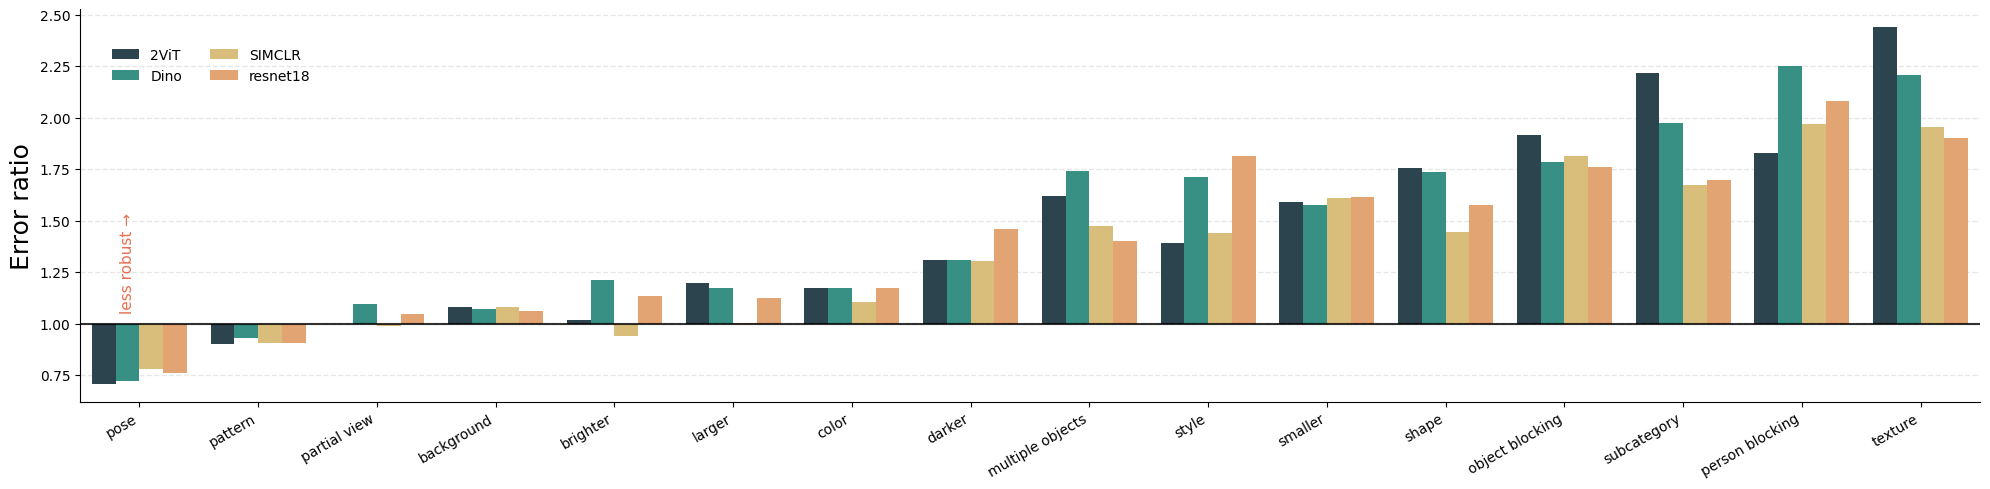

In [20]:
plots.set_color_palette()
plots.model_comparison(factor_accs.reset_index())

## Distribution plot top-1 factor

In [49]:
# read jsonl file

path = '../data/annotations/'
dftrain = pd.read_json(path + 'imagenet_x_train_top_factor.jsonl', lines=True)
dftrain_multi = pd.read_json(path + 'imagenet_x_train_multi_factor.jsonl', lines=True)
dfval = pd.read_json(path + 'imagenet_x_val_top_factor.jsonl', lines=True)
dfval_multi = pd.read_json(path + 'imagenet_x_val_multi_factor.jsonl', lines=True)


['pose', 'background', 'pattern', 'color']
['smaller', 'shape', 'partial view', 'subcategory']
['texture', 'darker', 'style', 'multiple objects']
['larger', 'object blocking', 'person blocking', 'brighter']


FileNotFoundError: [Errno 2] No such file or directory: '../../figures/1-sample30_distribution.png'

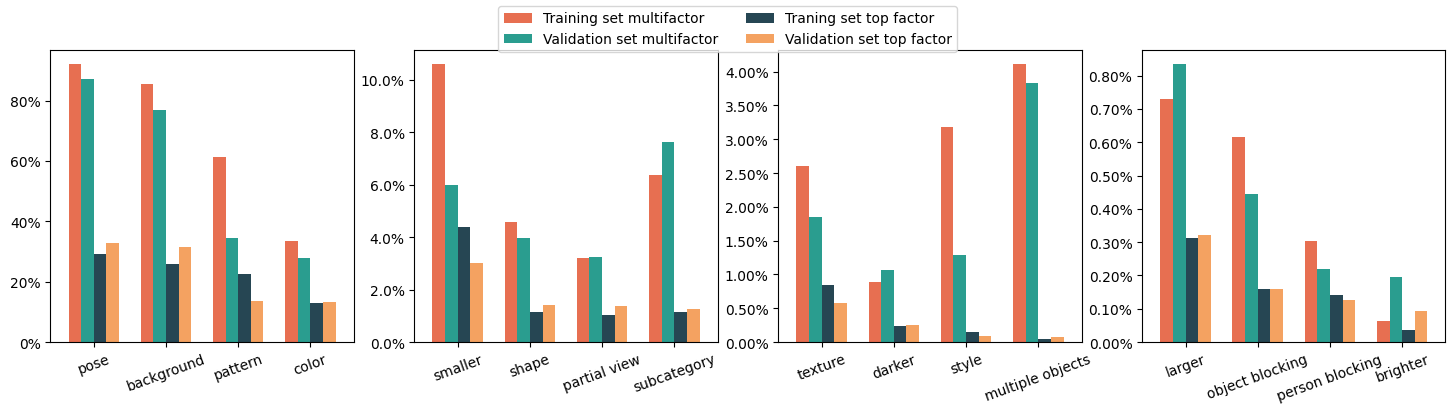

In [39]:
#Inspired by plots.factor_distribution_comparison()
dftrain_ = (dftrain.iloc[:,2:18]*100/len(dftrain)).sum()
dfval_ = (dfval.iloc[:,2:18]*100/len(dfval)).sum()
dftrain_multi_ = (dftrain_multi.iloc[:,2:18]*100/len(dftrain_multi)).sum()
dfval_multi_ = (dfval_multi.iloc[:,2:18]*100/len(dfval_multi)).sum()
dfko = pd.DataFrame.from_dict({ 'our multi val': dftrain_multi_, 'our multi train': dfval_multi_, 'our val': dftrain_, 'our train': dfval_})

colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]

fig, axs = plt.subplots(1,4,figsize=(18, 4))

cate =  [['pose', 'background', 'pattern', 'color'], [ 'smaller', 'shape', 'partial view', 'subcategory'], ['texture', 'darker', 'style', 'multiple objects'], ['larger', 'object blocking', 'person blocking', 'brighter'] ]
for i,ax in enumerate(axs):
    print(cate[i])
    dfko.index = dfko.index.str.replace('_', ' ')
    ax = dfko.loc[cate[i]].plot.bar(ax=ax,color=[colors[0],colors[1], colors[2], colors[3]],width=0.7,rot=20,legend=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(), )
    
fig.legend(['Training set multifactor','Validation set multifactor', 'Traning set top factor', 'Validation set top factor'], loc=9, ncol = 2)


#ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('../../figures/1-sample30_distribution.png', bbox_inches= 'tight')
plt.show()

In [36]:
dftrain_multi_ = dftrain_multi.iloc[:,2:18]
dfval_multi_ = dfval_multi.iloc[:,2:18]
df_all = pd.concat([dftrain_multi_, dfval_multi_])
df_all.columns = df_all.columns.str.replace('_', ' ')
Corr = df_all.corr()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0.5, 0, 'multiple objects'),
  Text(1.5, 0, 'background'),
  Text(2.5, 0, 'color'),
  Text(3.5, 0, 'brighter'),
  Text(4.5, 0, 'darker'),
  Text(5.5, 0, 'style'),
  Text(6.5, 0, 'larger'),
  Text(7.5, 0, 'smaller'),
  Text(8.5, 0, 'object blocking'),
  Text(9.5, 0, 'person blocking'),
  Text(10.5, 0, 'partial view'),
  Text(11.5, 0, 'pattern'),
  Text(12.5, 0, 'pose'),
  Text(13.5, 0, 'shape'),
  Text(14.5, 0, 'subcategory'),
  Text(15.5, 0, 'texture')])

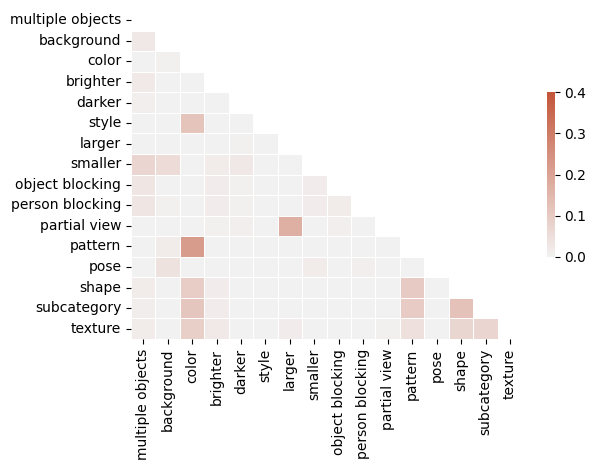

In [48]:
mask1 = Corr.abs() < 0.1
mask2 = np.triu(np.ones_like(Corr, dtype=bool))
mask = mask1 | mask2
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(Corr, annot=False, fmt='.2f', cmap=cmap, vmin=0.0, vmax=0.4, center=0, square=False, linewidths=.5, cbar_kws={"shrink": .5}, mask=mask2)
plt.tight_layout()
plt.xticks(rotation=90) 
plt.savefig('../../figures/1-sample30_correlation.png', bbox_inches= 'tight')